## Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth **MSA**). **MSA** methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)

We will use the files of XML format (*curated_uniprot.fasta_*) with the information of hsp regions and the amino acid sequences.

In [41]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os
from Bio.Blast import NCBIXML
import ipywidgets as widgets

In [42]:
# Check the current directory
print('Current working directory:', os.getcwd())

Current working directory: /Users/alina/HMM


In [43]:
directory = "/Users/alina/HMM"

### 1. Data Preparation

We have defined a function that parses an XML file into a pandas dataframe. This function can be utilized to include any additional columns from the BLAST results.

In [44]:
# Parse the XML file into a pandas dataframe
input_files = ['{}/curated_uniprot.fasta_75'.format(directory)]
dfs = []
max_query_length = 0

for input_file in input_files:
    with open(input_file) as f:
        blast_records = NCBIXML.parse(f)
        data = []

        # Iterate PSIBLAST rounds
        for blast_record in blast_records:
            query_id = blast_record.query

            # Get the length of the query sequence
            query_length = int(blast_record.query_letters)
            if query_length > max_query_length:
                max_query_length = query_length

            # Iterate alignments (here just one)
            for i, alignment in enumerate(blast_record.alignments):
                subject_id = alignment.title

                # Iterate pairwise alignments
                for hsp in alignment.hsps:
                    data.append((query_id.split(" ")[0], # it's not necessary to print the whole id
                                    subject_id.split(" ")[0], # the same as above
                                    query_length,
                                    hsp.align_length,
                                    hsp.query,
                                    hsp.match,
                                    hsp.sbjct,
                                    hsp.query_start,
                                    hsp.query_end,
                                    hsp.sbjct_start,
                                    hsp.sbjct_end,
                                    hsp.identities,
                                    hsp.positives,
                                    hsp.gaps,
                                    hsp.expect,
                                    hsp.score,
                                    ))

                    # Skip duplicated subjects
                    break

        dfs.append(pd.DataFrame(data, columns=["query_id", "subject_id", "query_len", "hsp_len", "query_seq",
                                               "match_seq", "subject_seq", "query_start", "query_end",
                                               "subject_start", "subject_end", "identity", "positive",
                                               "gaps", "eval", "bit_score"]))

In [45]:
# Print the resulting dataframe
df = dfs[0]
df.head()

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0


### 2. Query ID Analysis

Next, we determine the count of subject IDs for each query ID. It's important to note that we need to summarize the data for all subject IDs that occurred for a particular query, rather than for each individual 'query-sequence' pair.

In [46]:
# Calculate the counts of subject IDs for the query ID and expand the dataframe with the new column
grouped = df.groupby('query_id')['subject_id'].nunique().reset_index(name='count')
df = pd.merge(df, grouped, on='query_id')
df.head()

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200


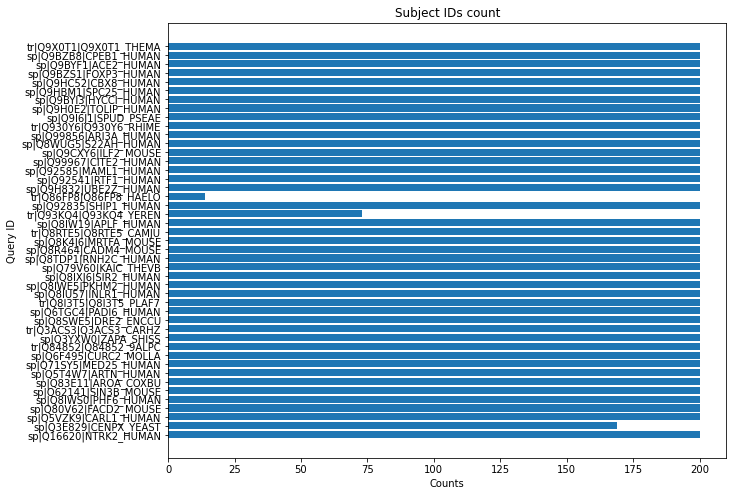

In [47]:
# Plot subject IDs count
figure(figsize=(10, 8))
plt.barh(df['query_id'], df['count'])
plt.xlabel('Counts')
plt.ylabel('Query ID')
plt.title('Subject IDs count')
plt.show()

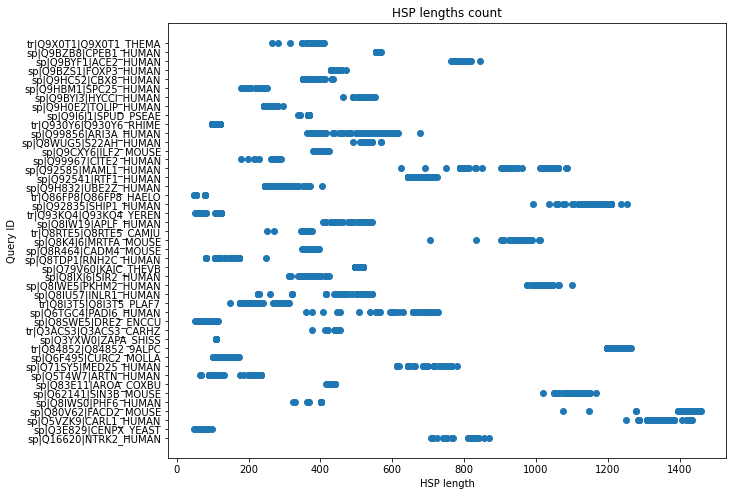

In [48]:
# Plot hsp length count
figure(figsize=(10, 8))
plt.scatter(df['hsp_len'], df['query_id'])
plt.xlabel('HSP length')
plt.ylabel('Query ID')
plt.title('HSP lengths count')
plt.show()

Previously, we presented the overall proportion of unique subjects for all query IDs, but now we intend to conduct a separate analysis for each query ID. To begin, we will create a dropdown list for the query ID.

In [49]:
# Dropdown list of query IDs
output = widgets.Select(
    options=df["query_id"].unique(),
    rows=10,
    description='Query ID: ',
    layout={'width': 'max-content'},
    disabled=False
)
display(output)

Select(description='Query ID: ', layout=Layout(width='max-content'), options=('sp|Q16620|NTRK2_HUMAN', 'sp|Q3E…

Once the query ID list is generated, we need to select one of the IDs.

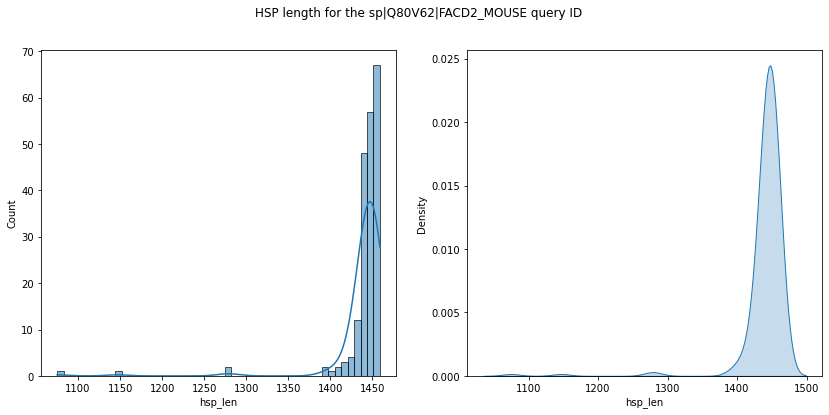

In [50]:
# Select query ID and filter dataframe
selected_id = output.value
selected = df[df["query_id"].isin([selected_id])]

# Create bar plot for HSP hits of selected query ID
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(selected['hsp_len'], kde = True, bins = 50, ax = ax1)
sns.kdeplot(selected['hsp_len'], shade = True, ax = ax2)
plt.suptitle(f'HSP length for the {selected_id} query ID')
plt.show()

The `histplot` shows the distribution of HSP lengths in the selected query ID by grouping the HSP lengths into bins or ranges along the x-axis and displaying the frequency of HSP lengths as the height of the corresponding bar on the y-axis. This provides a visual representation of the frequency and range of HSP lengths in the dataset and can be used to identify patterns or anomalies in the data.

The height of the `kdeplot` curve represents the estimated probability density of the variable being plotted at each point on the x-axis. For example, in the case of the HSP length, the height of the curve at a particular value of x represents the estimated density of observations around that value. The area under the curve represents the total probability of all possible values of the variable, which is equal to 1.

### 3. Multiple Sequence Alignment

In [11]:
n = df['query_seq'].str.len().max()
m = 
matrix = np.zeros((n,m))

SyntaxError: invalid syntax (777376442.py, line 2)